In [1]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.0.0
argon2-cffi                  21.1.0
astunparse                   1.6.3
attrs                        21.2.0
backcall                     0.2.0
bleach                       4.1.0
cachetools                   4.2.4
certifi                      2021.10.8
cffi                         1.15.0
charset-normalizer           2.0.7
click                        8.0.3
colorama                     0.4.4
cycler                       0.11.0
debugpy                      1.5.1
decorator                    5.1.0
defusedxml                   0.7.1
entrypoints                  0.3
flatbuffers                  2.0
gast                         0.4.0
google-auth                  2.3.3
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.41.1
h5py                         3.5.0
idna                         3.3
ipykernel                    6.5.0
ipython    

You should consider upgrading via the 'E:\lambda\labs\ds-test-2\venv2\Scripts\python.exe -m pip install --upgrade pip' command.


pandocfilters                1.5.0
parso                        0.8.2
pickleshare                  0.7.5
Pillow                       8.4.0
pip                          21.2.4
prometheus-client            0.12.0
prompt-toolkit               3.0.22
protobuf                     3.19.1
pyasn1                       0.4.8
pyasn1-modules               0.2.8
pycparser                    2.21
Pygments                     2.10.0
pyparsing                    2.4.7
pyrsistent                   0.18.0
python-dateutil              2.8.2
pytz                         2021.3
pywin32                      302
pywinpty                     1.1.5
pyzmq                        22.3.0
qtconsole                    5.2.0
QtPy                         1.11.2
requests                     2.26.0
requests-oauthlib            1.3.0
rsa                          4.7.2
Send2Trash                   1.8.0
setuptools                   58.2.0
six                          1.16.0
tensorboard                  2.7.0
tensorboard

This notebook was executed on:
- Windows 10
- Ryzen 3900x
- 32 GB ram
- Nvidia 3080

# Research question:
is it possible using the sythetic dataset provided by generate.py and samples of user input provided by story_photo_transformer.py to generate coordinates with less than 8pix mean average error.

---

## Hypothesis
Adding convolution layers to the beginning of the model will improve MAE to below baseline levels

In [2]:
#shared experiment variables
global_batch_size = 96
global_epochs = 1000
global_learning_rate =.00015

In [3]:
# graphing function
def display_history(hist):
    # plot history

    loss_p = hist.history['loss']
    val_loss_p = hist.history['val_loss']

    plt.figure(figsize=(15,5))
    plt.plot(loss_p, label='MAE (training data)')
    plt.title('MAE for points')
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    #plt.yscale('log',base=2)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(val_loss_p, label='MAE (validation data)')
    plt.title('MAE for points')
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    #plt.yscale('log',base=2)
    plt.show()


In [4]:
# this allows tensorflow to find my local cuda installation, remove this or change it to match your environment

#%set_env CUDA_PATH=e:\cuda\bin
#%set_env CUDA_PATH_V11_2=e:\cuda\bin
#%set_env PATH=%PATH%;e:\cuda\bin;e:\cuda\extras;e:\cuda\include;e:\cuda\lib

import os
os.add_dll_directory(r'e:\cuda\bin')

import json

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import glob

# this is the path to the synthetic data generated by generate.py, you may need to change this to match your system.
data_dir =r'..\..\..\models\synthetic_data\synthetic_data_for_pipeline_transform\data\*\*'
example_data_files = glob.glob(data_dir)[0:]
print(f'Example of data {example_data_files[0:3]}, {len(example_data_files)} records')

# load each of the X_input files using opencv and convert to BGR colorspace as required by opencv
X_train =[ cv2.cvtColor(cv2.imread(x),cv2.COLOR_RGB2BGR) for x in example_data_files if "X_input" in x ]
# load point data for each record
y_train =[ json.loads( open(y,'rb').read() )["y_label_points"] for y in example_data_files if ".json" in y ]

# convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape((X_train.shape[0],8))

# load real data
# this loads actual recorded user data that optimally we would like to predict with zero error.

path_real = r'..\..\..\data\transcribed_stories\*\*\phase0\*'
real_set=glob.glob(path_real)
# load and convert the data
X_real =np.array([ cv2.cvtColor(cv2.imread(x),cv2.COLOR_RGB2BGR) for x in real_set if "X_input" in x ])
y_real =[ json.loads(open(y,'rb').read() )["y_label_points"] for y in real_set if ".json" in y ]
y_real = np.array(y_real).reshape((X_real.shape[0],8))

assert (X_real.shape[0]==y_real.shape[0])
print(f'Sythetic  data contains {X_train.shape[0]} records.')
print(f'Real data contains {X_real.shape[0]} records.')

Example of data ['..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.json', '..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.X_input.png', '..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.y_label.png'], 22170 records
Sythetic  data contains 7390 records.
Real data contains 3 records.


In [5]:
c_init = keras.initializers.Constant(.004)
b_init = keras.initializers.Constant(.004)

img_inputs = keras.Input(shape=(256, 256-64, 3))
x = img_inputs
x = layers.Conv2D(32,(3,3),(3,3))(x)
x = tf.keras.layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)

outputs = layers.Dense(8,activation="relu",kernel_initializer=c_init,bias_initializer=b_init)(x)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="FC_Model")
model.summary()
model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(learning_rate=global_learning_rate))

Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 85, 64, 32)        896       
                                                                 
 re_lu (ReLU)                (None, 85, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 32, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 43008)             0         
                                                                 
 dense (Dense)               (None, 32)                1376288   
                                                          

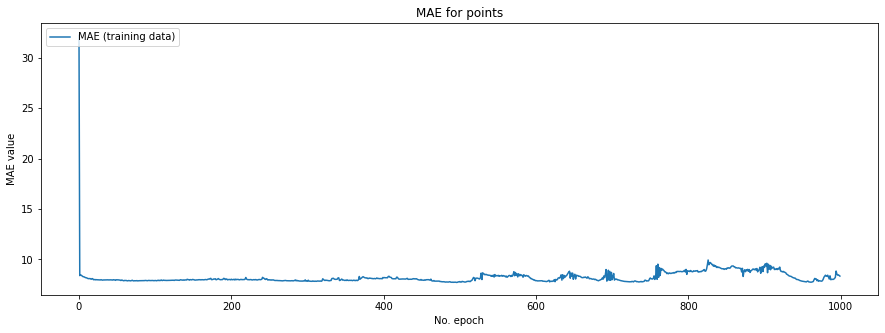

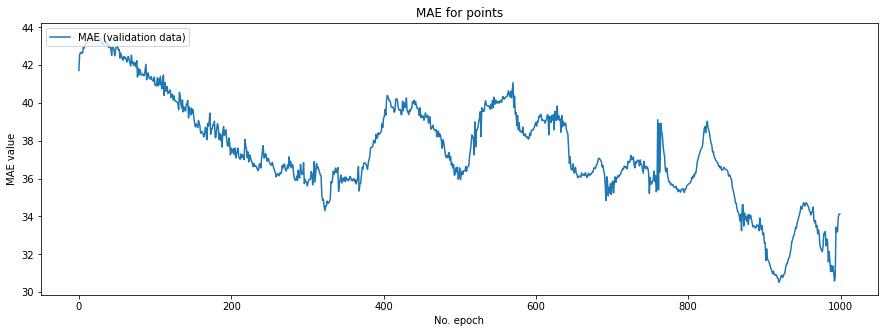

The minimum MAE achieved by the training was 7.710592746734619.
The minimum MAE achieved on the real data was 30.51340675354004.


In [6]:
tests=[]
for test in range(1):
    with tf.device("GPU"):
        history = model.fit(X_train,y_train,epochs=global_epochs,validation_data=(X_real,y_real),shuffle=False,verbose=0,
                            batch_size=global_batch_size)
        tests.append(history)


display_history(history)

min_loss = np.array(history.history['loss']).min()
min_val = np.array(history.history['val_loss']).min()
print(f'The minimum MAE achieved by the training was {min_loss}.')
print(f'The minimum MAE achieved on the real data was {min_val}.')

In [7]:
c_init = keras.initializers.Constant(.004)
b_init = keras.initializers.Constant(.004)

img_inputs = keras.Input(shape=(256, 256-64, 3))
x = img_inputs
x = layers.Conv2D(32,(3,3),(2,2))(x)
x = tf.keras.layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(x)
x = layers.Conv2D(64,(3,3),(2,2),data_format="channels_last")(x)
x = tf.keras.layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)

outputs = layers.Dense(8,activation="relu",kernel_initializer=c_init,bias_initializer=b_init)(x)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="FC_Model")
model.summary()
model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(learning_rate=global_learning_rate))

Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 95, 32)       896       
                                                                 
 re_lu_1 (ReLU)              (None, 127, 95, 32)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 23, 64)        18496     
                                                                 
 re_lu_2 (ReLU)              (None, 31, 23, 64)        0         
                                                          

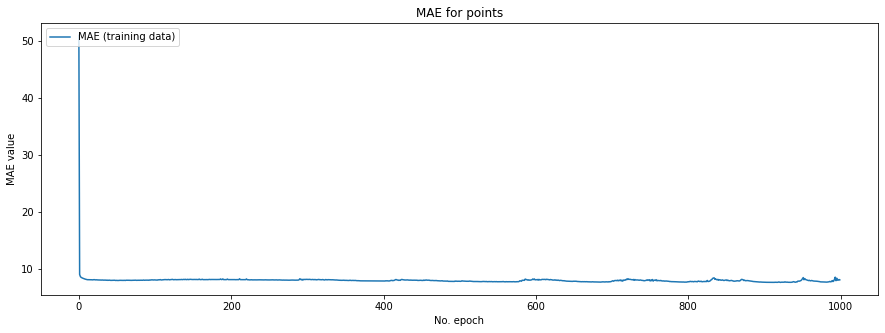

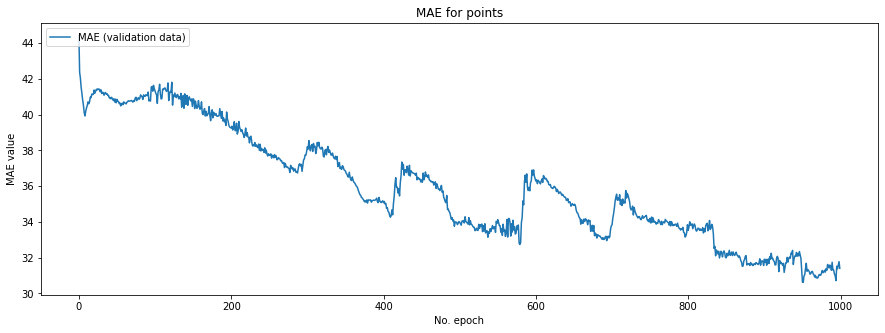

The minimum MAE achieved by the training was 7.555954456329346.
The minimum MAE achieved on the real data was 30.617279052734375.


In [8]:
tests=[]
for test in range(1):
    with tf.device("GPU"):
        history = model.fit(X_train,y_train,epochs=global_epochs,validation_data=(X_real,y_real),shuffle=False,verbose=0,
                            batch_size=global_batch_size)
        tests.append(history)


display_history(history)

min_loss = np.array(history.history['loss']).min()
min_val = np.array(history.history['val_loss']).min()
print(f'The minimum MAE achieved by the training was {min_loss}.')
print(f'The minimum MAE achieved on the real data was {min_val}.')


In [9]:
c_init = keras.initializers.Constant(.004)
b_init = keras.initializers.Constant(.004)

img_inputs = keras.Input(shape=(256, 256-64, 3))
x = img_inputs
x = layers.Conv2D(32,(3,3),(2,2))(x)
x = tf.keras.layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(x)
x = layers.Conv2D(64,(3,3),(2,2))(x)
x = tf.keras.layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(x)
x = layers.Conv2D(128,(3,3),(2,2))(x)
x = tf.keras.layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)

outputs = layers.Dense(8,activation="relu",kernel_initializer=c_init,bias_initializer=b_init)(x)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="FC_Model")
model.summary()
model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(learning_rate=global_learning_rate))

Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 127, 95, 32)       896       
                                                                 
 re_lu_3 (ReLU)              (None, 127, 95, 32)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 23, 64)        18496     
                                                                 
 re_lu_4 (ReLU)              (None, 31, 23, 64)        0         
                                                          

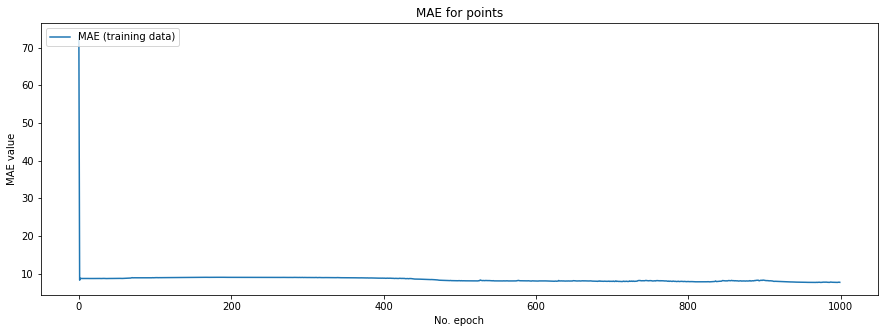

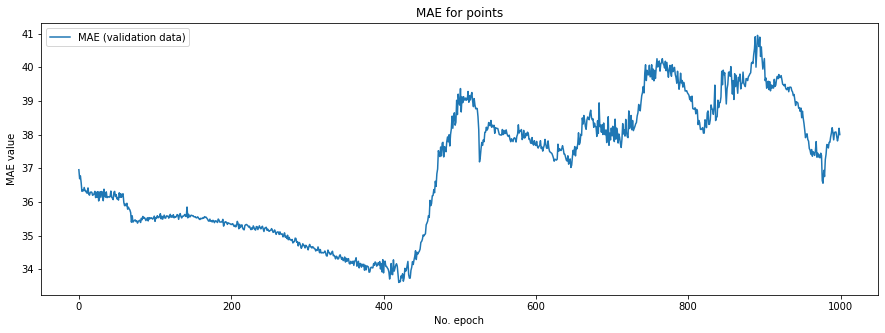

The minimum MAE achieved by the training was 7.659805774688721.
The minimum MAE achieved on the real data was 33.60559844970703.


In [10]:
tests=[]
for test in range(1):
    with tf.device("GPU"):
        history = model.fit(X_train,y_train,epochs=global_epochs,validation_data=(X_real,y_real),shuffle=False,verbose=0,
                            batch_size=global_batch_size)
        tests.append(history)


display_history(history)

min_loss = np.array(history.history['loss']).min()
min_val = np.array(history.history['val_loss']).min()
print(f'The minimum MAE achieved by the training was {min_loss}.')
print(f'The minimum MAE achieved on the real data was {min_val}.')



In [11]:
c_init = keras.initializers.Constant(.004)
b_init = keras.initializers.Constant(.004)

img_inputs = keras.Input(shape=(256, 256-64, 3))
x = img_inputs
x = layers.Conv2D(32,(3,3),(2,2))(x)
x = tf.keras.layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(x)
x = layers.Conv2D(32,(3,3),(2,2))(x)
x = tf.keras.layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(x)
x = layers.Conv2D(32,(3,3),(2,2))(x)
x = tf.keras.layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)

outputs = layers.Dense(8,activation="relu",kernel_initializer=c_init,bias_initializer=b_init)(x)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="FC_Model")
model.summary()
model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(learning_rate=global_learning_rate))

Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 127, 95, 32)       896       
                                                                 
 re_lu_6 (ReLU)              (None, 127, 95, 32)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 31, 23, 32)        9248      
                                                                 
 re_lu_7 (ReLU)              (None, 31, 23, 32)        0         
                                                          

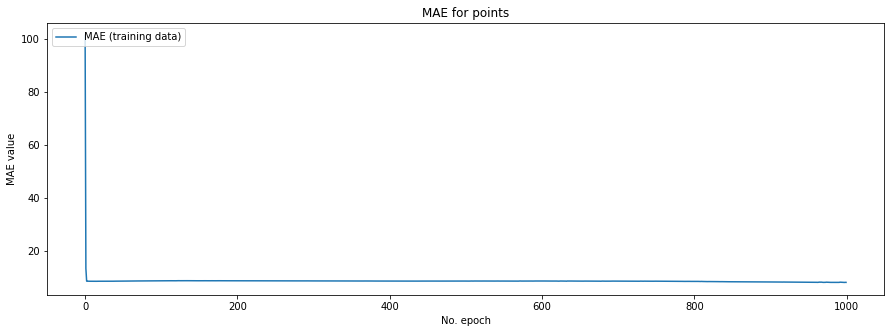

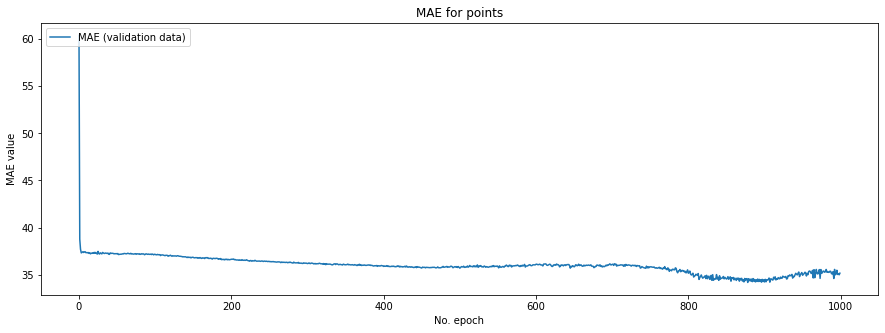

The minimum MAE achieved by the training was 8.287229537963867.
The minimum MAE achieved on the real data was 34.185611724853516.


In [12]:
tests=[]
for test in range(1):
    with tf.device("GPU"):
        history = model.fit(X_train,y_train,epochs=global_epochs,validation_data=(X_real,y_real),shuffle=False,verbose=0,
                            batch_size=global_batch_size)
        tests.append(history)


display_history(history)

min_loss = np.array(history.history['loss']).min()
min_val = np.array(history.history['val_loss']).min()
print(f'The minimum MAE achieved by the training was {min_loss}.')
print(f'The minimum MAE achieved on the real data was {min_val}.')